In [51]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import glob
import shutil
import os

In [52]:
def get_center(inputfilename):
    file = fits.open(inputfilename)
    #WCS info from header
    CRVAL1 = file[1].header['CRVAL1']
    CRVAL2 = file[1].header['CRVAL2']
    CRPIX1 = file[1].header['CRPIX1']
    CRPIX2 = file[1].header['CRPIX2']
    CD1_1 = file[1].header['CD1_1']
    CD1_2 = file[1].header['CD1_2']
    CD2_1 = file[1].header['CD2_1']
    CD2_2 = file[1].header['CD2_2']
    
    A = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
    A_inv = np.linalg.inv(A)
    B = np.array([[CRVAL1],[CRVAL2]])
    r0 = np.array([[CRPIX1],[CRPIX2]])
    
    def coo_pixtosky(r):
        return np.matmul(A, r-r0) + B
    
    def coo_skytopix(r_sky):
        return np.matmul(A_inv, r_sky - B) + r0
    
    #Target location info
    RA_TARG = file[0].header['RA_TARG'] 
    DEC_TARG = file[0].header['DEC_TARG']
    r_sky_TARG = np.array([[RA_TARG], [DEC_TARG]])
    X_TARG, Y_TARG = int(coo_skytopix(r_sky_TARG)[0]), int(coo_skytopix(r_sky_TARG)[1])
    
    data = file[1].data
    
    s = 100
    max_i = 0
    max_j = 0
    maxval = 0
    for i in range(Y_TARG-s, Y_TARG+s+1):
        for j in range(X_TARG-s, X_TARG+s+1):
            if data[i][j] > maxval:
                maxval = data[i][j]
                max_i = i
                max_j = j 
    r = 50
    total_flux = 0
    i_integral = 0
    j_integral = 0
    for i in range(max_i-r, max_i+r+1):
        for j in range(max_j-r, max_j+r+1):
            total_flux += data[i][j]
            i_integral += i*data[i][j]
            j_integral += j*data[i][j]
    
    i_center = i_integral/total_flux
    j_center = j_integral/total_flux
    
    X_center = j_center +1
    Y_center = i_center +1
    r_center = np.array([[X_center], [Y_center]])
    

    return (X_center), (Y_center)

In [53]:
path = '/Users/ha/Makani_Project/'
lst_raw = glob.glob(path + '/data/*/*/*raw.fits')
dark_lst = glob.glob(path + '/darks/HST/*/*raw.fits')

Function to create an average dark from archived data knowing a upper temperature

Flag out the galaxy from each frame ( real data )

In [54]:
%%time
#dark_file = fits.open('avg_dark_archived_uppertemp24.fits')
total_exptime = 0

for i in range(len(lst_raw)):
    flaged_table = np.ones((1024,1024))
    flaged_subtracted = np.zeros((1024, 1024))
    
    filename = lst_raw[i]
    rawfile = fits.open(filename)
    rawdata = rawfile[1].data
    exptime = rawfile[0].header['EXPTIME']
    rootname = rawfile[0].header['ROOTNAME']
    
    x_center, y_center = get_center(filename)
    if np.isnan(x_center) or np.isnan(y_center):
        continue
    x_center, y_center = int(x_center), int(y_center)    
    
    #flag_table; flag_subtracted table
    flaged_subtracted = fits.open(filename)[1].data
    
    e = 30
    for i in range(y_center -e, y_center + e):
        for j in range(x_center - e, x_center + e):
            flaged_table[i][j] = 0.0
            flaged_subtracted[i][j] = 0

            
    #create a flaged file
    Primary = rawfile['Primary']
    SCI = fits.ImageHDU(rawdata, name = 'SCI', header = rawfile['SCI'].header)
    FLAG = fits.ImageHDU(flaged_table, name = 'FLAG')
    FLAG_subtracted = fits.ImageHDU(flaged_subtracted, name = 'FS')
    hdul = fits.HDUList([Primary, SCI, FLAG, FLAG_subtracted])
    hdul.writeto(rootname + '_flaged.fits', overwrite = True)
    
    
    #create a subtracted file
    #dark_frame = dark_file[0].data * exptime
    #new_data = rawdata - dark_frame
    
    #subtracted_SCI = fits.ImageHDU(new_data, name = 'SCI', header = rawfile['SCI'].header)
    #subtracted_hdul = fits.HDUList([Primary, subtracted_SCI, FLAG])
    #subtracted_hdul.writeto(filename[-18:-9] + '_subtracted_24.fits', overwrite = True)
    

/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in long_scalars
/Users/ha/.conda/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 5.24 s, sys: 1.48 s, total: 6.72 s
Wall time: 9.11 s


In [55]:
directory_name = 'flaged'
parent_path = '/Users/ha/Makani_Project/Testxviiii'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [56]:
old_flaged_lst = glob.glob('*_flaged.fits')
for files_path in old_flaged_lst:
    shutil.move(files_path, path)

Combine all the flaged file to create a new dark frame

In [57]:
%%time
flaged_lst =  glob.glob('flaged/*_flaged.fits')
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
for filename in flaged_lst:
        file = fits.open(filename)
        data = file[1].data
        flaged_table = file['FLAG'].data
        flaged_subtracted = file['FS'].data
        exptime = file[0].header['EXPTIME']

        exptime_table += exptime * flaged_table
        sumdata_1subtracted += flaged_subtracted
        #print(file[0].header['DATE'])
for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('avg_dark_summed_data.fits', overwrite = True)

CPU times: user 912 ms, sys: 234 ms, total: 1.15 s
Wall time: 3.18 s


In [58]:
arch_temp_2022 = []
arch_darks_2022 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2022 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2022.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2022.append(darks)

arch_temp_2021 = []
arch_darks_2021 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2021 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2021.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2021.append(darks)
        
arch_temp_2020 = []
arch_darks_2020 = []
for item in dark_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    year = int(file[0].header['DATE-OBS'][:4])
    data_ps = file[1].data/ exptime
    
    if year == 2020 and temp >= 0.0 and temp <= 30.0:
        arch_temp_2020.append(temp)
        sample = data_ps[471: 822, 471:822]
        darks = sum(sum(sample)) / (len(sample) * len(sample[0]))
        arch_darks_2020.append(darks)
        
data_temp = []
data_darks = []
for item in flaged_lst:
    file = fits.open(item)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    data_ps = file[1].data/ exptime
    
    data_temp.append(temp)
    sample = data_ps[471:822 , 471:822]
    darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
    data_darks.append(darks)


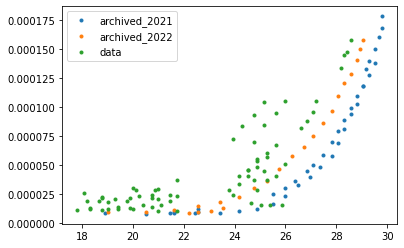

In [59]:
#plt.plot(arch_temp_2020, arch_darks_2020, '.', label = 'archived_2020')    
plt.plot(arch_temp_2021, arch_darks_2021, '.', label = 'archived_2021')
plt.plot(arch_temp_2022, arch_darks_2022, '.', label = 'archived_2022')
plt.plot(data_temp, data_darks, '.', label = 'data')
plt.legend()

In [60]:
data_temp = []
data_darks = []
visit_lst = [1, 3, 4, 5, 7, 8, 9, 10, 56, 57, 58]
for visit_num in visit_lst:
    l = []
    t = []
    for item in flaged_lst:
        file = fits.open(item)
        exptime = file[0].header['EXPTIME']
        temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        year = (file[0].header['DATE-OBS'])
        data_ps = file[1].data/ exptime
        visit = int(file[0].header['LINENUM'][:2])
        
        if visit == visit_num:
            #print(visit_num, year)

            t.append(temp)
            sample = data_ps[471:822 , 471:822]
            #sample = data_ps
            darks = sum(sum(sample)) /( (len(sample) * len(sample[0])) - (2*e)**2)
            l.append(darks)
    data_darks.append(l)
    data_temp.append(t)

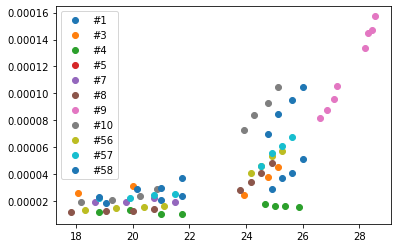

In [61]:
for i in range(len(data_darks)):
    plt.plot(data_temp[i], data_darks[i], 'o', label = '#'+str(visit_lst[i]))
    plt.legend()
    #plt.show()

Create primary dark

# CHECKPOINT

In [91]:
uptemp = 20

In [92]:
%%time
sumdata_1subtracted = np.zeros((1024,1024))
exptime_table = np.zeros((1024,1024))
num_files_combined = 0
for filename in flaged_lst:
    file = fits.open(filename)
    data = file[1].data
    flaged_table = file['FLAG'].data
    flaged_subtracted = file['FS'].data
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
        
    if temp > uptemp:
        continue
    num_files_combined += 1
    exptime_table += exptime * flaged_table
    sumdata_1subtracted += flaged_subtracted
        
for filename in dark_lst:
    file = fits.open(filename)
    data = file[1].data
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    flaged_table = np.ones((1024, 1024))
    year = int(file[0].header['DATE-OBS'][:4])
    if temp <= uptemp and temp >= 0.0 and year >= 2020:
        num_files_combined += 1
        exptime_table += exptime * flaged_table
        sumdata_1subtracted += data

for i in range(0, 1024):
    for j in range(0, 1024):
        sumdata_1subtracted[i][j] /= exptime_table[i][j]

print(num_files_combined)
Primary = fits.PrimaryHDU()
SCI = fits.ImageHDU(sumdata_1subtracted, name = 'SCI')
hdul = fits.HDUList([Primary, SCI])
hdul.writeto('primary_dark_uptemp_'+str(uptemp)+'.fits', overwrite = True)

23
CPU times: user 2.15 s, sys: 151 ms, total: 2.3 s
Wall time: 2.97 s


Primary Dark Subtraction

In [93]:
pri_dark = fits.open('primary_dark_uptemp_'+str(uptemp)+'.fits')
dark_data = pri_dark[1].data

for filename in flaged_lst:
    file = fits.open(filename)
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    real_data = file[1].data
    rootname = file[0].header['ROOTNAME']
    new_data = real_data - dark_data * exptime 
    
    Primary = file[0]
    SCI = fits.ImageHDU(new_data, header = file[1].header, name = 'SCI')
    
    hdul = fits.HDUList([Primary, SCI])
    
    hdul.writeto(rootname + '_1subtracted_'+str(uptemp)+'.fits', overwrite = True)

In [94]:
directory_name = '1subtracted_' + str(uptemp)
parent_path = '/Users/ha/Makani_Project/Testxviiii'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [95]:
old_1subtracted_lst = glob.glob('*_1subtracted_'+str(uptemp)+'.fits')
for files_path in old_1subtracted_lst:
    shutil.move(files_path, path)

In [96]:
pri_subtracted_lst = glob.glob('1subtracted_'+str(uptemp)+'/*_1subtracted_'+str(uptemp)+'.fits')

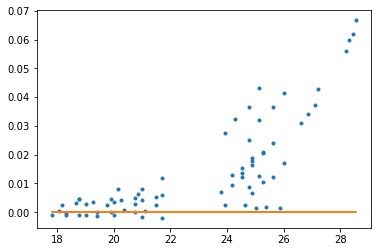

In [97]:
width_2dark = 300
x_2dark = 600
y_2dark = 650
temps = []
res = []
for filename in pri_subtracted_lst:
    #print(filename)
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    e = 50
    for i in range(Y_center - e, Y_center + e):
        for j in range(X_center - e, X_center + e):
            data[i][j] = 0
    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]

    temps.append(temp)
    res.append( sum(sum(sample)) / (sample.size - e**2) )    

#temps_24 = []
#res_24 = []
#for filename in pri_subtracted_lst_24:
#    #print(filename)
#    file = fits.open(filename)
#    data = file[1].data
#    
#    exptime = file[0].header['EXPTIME']
#    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
#    X_center = int(get_center(filename)[0])
#    Y_center = int(get_center(filename)[1])
#    
#    e = 50
#    for i in range(Y_center - e, Y_center + e):
#        for j in range(X_center - e, X_center + e):
#            data[i][j] = 0
#    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
#                                   x_2dark - width_2dark: x_2dark + width_2dark]
#    
#    temps_24.append(temp)
#    res_24.append( sum(sum(sample)) / (sample.size - e**2) )
plt.plot(temps, res, '.')
plt.plot(temps, [0] * len(temps))
#plt.plot(temps_24, res_24, '.')

In [98]:
res.sort()
res

[-0.0019882627191084795,
 -0.0016229626807311515,
 -0.001198235305384269,
 -0.0010928940479836688,
 -0.001077702019857527,
 -0.0010655244069638164,
 -0.0010392327549146954,
 -0.0009192630086301806,
 -0.0003451817307732954,
 3.415137742337259e-05,
 9.13176642568903e-05,
 0.00010309957322822301,
 0.00043836672028805504,
 0.0005142487745800184,
 0.0006099454165126108,
 0.0014042486419214178,
 0.0015550192770562425,
 0.001766104952701684,
 0.0023434879288884657,
 0.0024193641090016946,
 0.0024784469413967865,
 0.0024902269042720005,
 0.002579843512490029,
 0.002855449902308707,
 0.0030110928151017877,
 0.00312625061690699,
 0.0034150319279962495,
 0.0035046743318119336,
 0.004183433590869031,
 0.004192899250264317,
 0.004430534335778892,
 0.004430602541540733,
 0.004449645757749705,
 0.004765602773997626,
 0.005389246143659783,
 0.006059557077767077,
 0.006476798378751153,
 0.006531096274356935,
 0.0070806094808068066,
 0.007965701107709493,
 0.007995584445335787,
 0.0086613542880721,
 0.0

Create secondary dark

In [99]:
pri_dark = fits.open('primary_dark_uptemp_'+str(uptemp)+'.fits')
real_dark = fits.open('avg_dark_summed_data.fits')

pri_dark_data = pri_dark[1].data
real_dark_data = real_dark[1].data

data = real_dark_data - pri_dark_data
Primary = fits.PrimaryHDU(data)
hdul = fits.HDUList([Primary])
hdul.writeto('secondary_dark_'+str(uptemp)+'.fits', overwrite = True)

Secondary Dark Subtraction

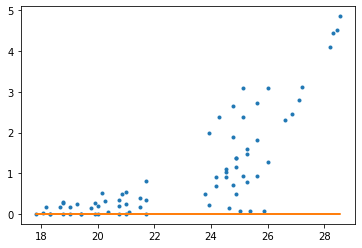

CPU times: user 9.32 s, sys: 1.14 s, total: 10.5 s
Wall time: 14.1 s


In [100]:
%%time
width_2dark = 200
x_2dark = 600
y_2dark = 650
sec_dark = fits.open('secondary_dark_'+str(uptemp)+'.fits')
data_2dark = sec_dark[0].data
sec_dark_sample = data_2dark[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]
A_2dark_ps = sum(sum(sec_dark_sample)) / (sec_dark_sample.size) 

temps = []
coeffs = []
for filename in pri_subtracted_lst:
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    rootname = file[0].header['ROOTNAME']
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    
    sumdata = 0
    num_val = 0
    e = 50
    for i in range(y_2dark - width_2dark, y_2dark + width_2dark):
        for j in range(x_2dark - width_2dark, x_2dark + width_2dark):
            if i >= Y_center - e and i < Y_center + e and j >= X_center - e and j< X_center + e:
                continue
            sumdata += data[i][j]
            num_val += 1
    
    A_data = sumdata/ num_val 
    
    k = A_data/( A_2dark_ps * exptime) 
    if k < 0:
        k = 0
    coeffs.append(k)
    temps.append(temp)
    
    new_data = data - k * data_2dark * exptime
    Primary = file[0]
    SCI = fits.ImageHDU(new_data, header = file[1].header, name = 'SCI')
    
    hdul = fits.HDUList([Primary, SCI])
    
    hdul.writeto(rootname + '_2subtracted_'+str(uptemp)+'.fits', overwrite = True)
    #print(temp, np.median(coeff))
plt.plot(temps,coeffs, '.')
plt.plot(temps, [0] * len(temps))
plt.show()

In [101]:
coeffs.sort()
coeffs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.0018161386536448758,
 0.02949977816591643,
 0.0385463497688096,
 0.045678429596996764,
 0.06601055365672487,
 0.06887530143745083,
 0.08002836540885373,
 0.13959458277897405,
 0.15170702740901698,
 0.1608550277993513,
 0.16258412596989436,
 0.1795573054205299,
 0.18051809267194135,
 0.18800723763499586,
 0.19727563680094215,
 0.2101980245246246,
 0.23830896786051028,
 0.25025431474800863,
 0.27497479607320513,
 0.2767578160302519,
 0.28388989585843877,
 0.31659979895195123,
 0.33710625771789654,
 0.3391988372695947,
 0.3826692014787585,
 0.49116022548623484,
 0.4943454949035538,
 0.4965577462980578,
 0.5149692822913317,
 0.5417442817542543,
 0.6941166459248953,
 0.6987785573395213,
 0.774626358525019,
 0.8035890655336239,
 0.9034853433476178,
 0.913082889748999,
 0.9266028321996471,
 0.9359159498730671,
 1.0414498602685118,
 1.095791736056774,
 1.1587089846880505,
 1.2821331655942276,
 1.3683106900592243,
 1.3737651170152954,
 1.4640531461

In [102]:
directory_name = '2subtracted_' + str(uptemp)
parent_path = '/Users/ha/Makani_Project/Testxviiii'
path = os.path.join(parent_path, directory_name)
os.makedirs(path)

In [103]:
old_2subtracted_lst = glob.glob('*_2subtracted_'+str(uptemp)+'.fits')
for files_path in old_2subtracted_lst:
    shutil.move(files_path, path)

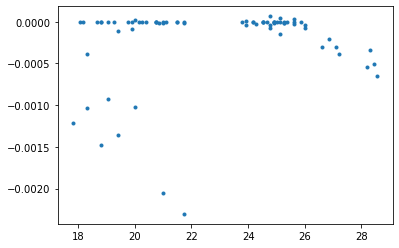

In [105]:
#sec_subtracted_lst_24 = glob.glob('2subtracted_'+str(24)+'/*_2subtracted_'+str(24)+'.fits')
sec_subtracted_lst= glob.glob('2subtracted_'+str(uptemp)+'/*_2subtracted_'+str(uptemp)+'.fits')
temps_20 = []
res_20 = []
for filename in sec_subtracted_lst:
    #print(filename)
    file = fits.open(filename)
    data = file[1].data
    
    exptime = file[0].header['EXPTIME']
    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
    X_center = int(get_center(filename)[0])
    Y_center = int(get_center(filename)[1])
    
    e = 50
    for i in range(Y_center - e, Y_center + e):
        for j in range(X_center - e, X_center + e):
            data[i][j] = 0
    
    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
                                   x_2dark - width_2dark: x_2dark + width_2dark]    
    temps_20.append(temp)
    res_20.append( sum(sum(sample)) / (sample.size - e**2) )    

#temps_24 = []
#res_24 = []
#for filename in sec_subtracted_lst_24:
#    #print(filename)
#    file = fits.open(filename)
#    data = file[1].data
    
#    exptime = file[0].header['EXPTIME']
#    temp = (file[1].header['MDECODT1'] + file[1].header['MDECODT2']) /2 
#    X_center = int(get_center(filename)[0])
#    Y_center = int(get_center(filename)[1])
    
#    e = 50
#    for i in range(Y_center - e, Y_center + e):
#        for j in range(X_center - e, X_center + e):
#            data[i][j] = 0
#    sample = data[y_2dark - width_2dark: y_2dark + width_2dark,
#                                   x_2dark - width_2dark: x_2dark + width_2dark]
    
#    temps_24.append(temp)
#    res_24.append( sum(sum(sample)) / (sample.size - e**2) )
plt.plot(temps_20, res_20, '.')
#plt.plot(temps_24, res_24, '.')